# Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li>
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB`
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

!pip install chart_studio
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Loading Data

In [ ]:
# make sure you are loading atleast 50k datapoints
# you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv')

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# Split the dataset
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
x_train, y_train = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print("Capitial" ,"X","represents the original train_data and lower case" ,"x", "represnts the ramdonly over-sampled data")

Resampled dataset shape Counter({1: 41615, 0: 41615})
Capitial X represents the original train_data and lower case x represnts the ramdonly over-sampled data


In [ ]:
# here we have to convert x into a dataframe
x_train = pd.DataFrame(x_train,columns = X.columns)
x_train.shape
# s = Project_data['project_is_approved'].value_counts()
# s

(83230, 8)

In [ ]:
print("Shape of Train data ",x_train.shape, y_train.shape)
print("="*100)
print("Shape of Train CV  data ",X_cv.shape, y_cv.shape)
print("="*100)
print("Shape of Test data ",X_test.shape, y_test.shape)
print("="*100)

Shape of Train data  (83230, 8) (83230,)
Shape of Train CV  data  (24155, 8) (24155,)
Shape of Test data  (36052, 8) (36052,)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay'
print(x_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_ess = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=50000)
vectorizer_ess.fit(x_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_bow = vectorizer_ess.transform(x_train['essay'].values)
X_cv_essay_bow = vectorizer_ess.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer_ess.transform(X_test['essay'].values)

print("After BoW vectorizations")
print(x_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)


(83230, 8) (83230,)
(24155, 8) (24155,)
(36052, 8) (36052,)
After BoW vectorizations
(83230, 50000) (83230,)
(24155, 50000) (24155,)
(36052, 50000) (36052,)


In [ ]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay'
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(x_train['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
x_train_essay_tfidf = vectorizer.transform(x_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After TFIDF vectorizations")
print(x_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)


After TFIDF vectorizations
(83230, 15111) (83230,)
(24155, 15111) (24155,)
(36052, 15111) (36052,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### 1.4.1 Encoding clean_subcategories

In [ ]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
vectorizer_csc = CountVectorizer(binary=True)
vectorizer_csc.fit(x_train['clean_subcategories']) # fit has to happen only on train data


# we use the fitted CountVectorizer to convert the text to vector
x_train_cleansubcat_ohe = vectorizer_csc.transform(x_train['clean_subcategories'])
X_cv_cleansubcat_ohe = vectorizer_csc.transform(X_cv['clean_subcategories'])
X_test_cleansubcat_ohe = vectorizer_csc.transform(X_test['clean_subcategories'])

print("After vectorizations of the clean_subcategories , One-hot-encoding shape of the data is")
print(x_train_cleansubcat_ohe.shape, y_train.shape)
print(X_cv_cleansubcat_ohe.shape, y_cv.shape)
print(X_test_cleansubcat_ohe.shape, y_test.shape)

After vectorizations of the clean_subcategories , One-hot-encoding shape of the data is
(83230, 30) (83230,)
(24155, 30) (24155,)
(36052, 30) (36052,)


### 1.4.2 Encoding clean_categories

In [ ]:
vectorizer_cc = CountVectorizer(binary=True)
vectorizer_cc.fit(x_train['clean_categories']) # fit has to happen only on train data


# we use the fitted CountVectorizer to convert the text to vector
x_train_cc_ohe = vectorizer_cc.transform(x_train['clean_categories'])
X_cv_cc_ohe = vectorizer_cc.transform(X_cv['clean_categories'])
X_test_cc_ohe = vectorizer_cc.transform(X_test['clean_categories'])

print("After vectorizations of the clean_categories, One-hot-encoding shape of the data is")
print(x_train_cc_ohe.shape, y_train.shape)
print(X_cv_cc_ohe.shape, y_cv.shape)
print(X_test_cc_ohe.shape, y_test.shape)

After vectorizations of the clean_categories, One-hot-encoding shape of the data is
(83230, 9) (83230,)
(24155, 9) (24155,)
(36052, 9) (36052,)


### 1.4.3 Encoding teacher_prefix



In [ ]:
vectorizer_tp = CountVectorizer(binary=True)
vectorizer_tp.fit(x_train['teacher_prefix'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_tp_ohe = vectorizer_tp.transform(x_train['teacher_prefix'].values.astype('U'))
X_cv_tp_ohe = vectorizer_tp.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_tp_ohe = vectorizer_tp.transform(X_test['teacher_prefix'].values.astype('U'))

print("After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is")
print(x_train_tp_ohe.shape, y_train.shape)
print(X_cv_tp_ohe.shape, y_cv.shape)
print(X_test_tp_ohe.shape, y_test.shape)

After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is
(83230, 5) (83230,)
(24155, 5) (24155,)
(36052, 5) (36052,)


### 1.4.4 Encoding school_state

In [ ]:
vectorizer_ss = CountVectorizer(binary=True)
vectorizer_ss.fit(x_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_state_ohe = vectorizer_ss.transform(x_train['school_state'].values)
X_cv_state_ohe = vectorizer_ss.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer_ss.transform(X_test['school_state'].values)

print("After vectorizations of the school_state , One-hot-encoding shape of the data is")
print(x_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)

After vectorizations of the school_state , One-hot-encoding shape of the data is
(83230, 51) (83230,)
(24155, 51) (24155,)
(36052, 51) (36052,)


### 1.4.5 Encoding project_grade_category

In [ ]:
vectorizer_pgc = CountVectorizer(binary=True)
vectorizer_pgc.fit(x_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_grade_ohe = vectorizer_pgc.transform(x_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer_pgc.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer_pgc.transform(X_test['project_grade_category'].values)

print("After vectorizations of the project_grade_category , One-hot-encoding shape of the data is")
print(x_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape,y_test.shape)

After vectorizations of the project_grade_category , One-hot-encoding shape of the data is
(83230, 4) (83230,)
(24155, 4) (24155,)
(36052, 4) (36052,)


### 1.4.6 Normalising price feature

In [ ]:
from sklearn.preprocessing import Normalizer
norm_vec1 = Normalizer()
norm_vec1.fit(x_train['price'].values.reshape(-1,1))                     # used .reshape(-1, 1) to avoid

x_train_price_norm = norm_vec1.transform(x_train['price'].values.reshape(-1,1))
X_cv_price_norm = norm_vec1.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = norm_vec1.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations of the price data ,  shape of the data after standazing")
print(x_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations of the price data ,  shape of the data after standazing
(83230, 1) (83230,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 1.4.7 Normalising teacher_number_of_previously_posted_projects feature

In [ ]:
from sklearn.preprocessing import Normalizer
norm_vec2 = Normalizer()
norm_vec2.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_projects_norm = norm_vec2.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_projects_norm = norm_vec2.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects_norm = norm_vec2.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing")
print(x_train_projects_norm.shape, y_train.shape)
print(X_cv_projects_norm.shape,y_cv.shape)
print(X_test_projects_norm.shape, y_test.shape)

After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing
(83230, 1) (83230,)
(24155, 1) (24155,)
(36052, 1) (36052,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

### 1.5.1 Stacking up all the features for Set 1

In [ ]:
from scipy.sparse import hstack
X1_tr = hstack((x_train_cc_ohe,x_train_cleansubcat_ohe,x_train_tp_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_essay_bow,x_train_price_norm,x_train_projects_norm)).tocsr()
X1_cv = hstack((X_cv_cc_ohe,X_cv_cleansubcat_ohe,X_cv_tp_ohe,X_cv_state_ohe,\
                X_cv_grade_ohe,X_cv_essay_bow,X_cv_price_norm,X_cv_projects_norm)).tocsr()
X1_te =hstack((X_test_cc_ohe,X_test_cleansubcat_ohe,X_test_tp_ohe,X_test_state_ohe,\
                X_test_grade_ohe,X_test_essay_bow,X_test_price_norm,X_test_projects_norm)).tocsr()


print("Final Data matrix")
print(X1_tr.shape, y_train.shape)
print(X1_cv.shape, y_cv.shape)
print(X1_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(83230, 50101) (83230,)
(24155, 50101) (24155,)
(36052, 50101) (36052,)


### 1.5.2 Hyperparameter Tuning and plot for the training and the CV AUC scores, for different values of 'alpha'.

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Ploting the Log values of alpha as it would exactly plot the values of the point's considered 


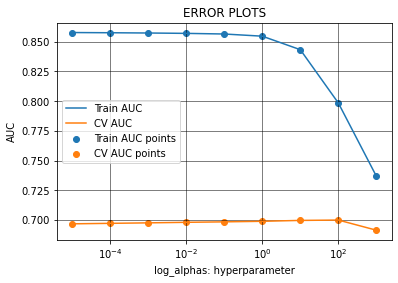

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]
for i in tqdm(alpha):
    neigh = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    neigh.fit(X1_tr, y_train)

    y_train_pred = neigh.predict_proba(X1_tr)[:,1]
    y_cv_pred = neigh.predict_proba(X1_cv)[:,1]

    # roc_auc_score(y_tr, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
print("Ploting the Log values of alpha as it would exactly plot the values of the point's considered ")
plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



In [ ]:
alpha1= 100
print("The Error Plot above shows the best Aplha value as :" , alpha1 )

The Error Plot above shows the best Aplha value as : 100


In [ ]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=alpha1,class_prior=[0.5,0.5])
neigh.fit(X1_tr, y_train)
y_train_pred = neigh.predict_proba(X1_tr)[:,1]
y_test_pred = neigh.predict_proba(X1_te)[:,1]


# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.


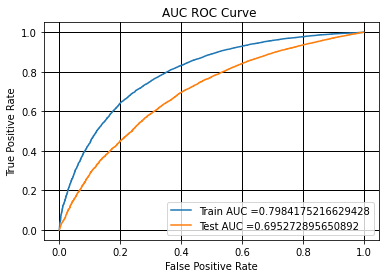

In [ ]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC ROC Curve ")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

In [ ]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)


#this is the custom function for predecting the best thershold and sorting the values according the threshould
def best_threshold_value(threshold, fpr, tpr):
    n = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),3), "for threshold", np.round(n,3))
    return n

# we only set the threshold by using the train data and the test data is not altered at any time , as it could cause the data leakeage problem
def predict_with_best_n(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("="*100)
from sklearn.metrics import confusion_matrix
best_n = best_threshold_value(tr_thresholds, train_fpr, train_tpr)
print("Confusion matrix for Train data")

print("TN, FP, FN, TP", "=", confusion_matrix(y_train, predict_with_best_n(y_train_pred, best_n)).ravel())
print("Confusion matrix for Test data")

print("TN, FP, FN, TP", "=", confusion_matrix(y_test, predict_with_best_n(y_test_pred, best_n)).ravel())
print("Here the threshold is ", np.round(best_n,3) , "We can change the threshold values according to requirement in the confusion matrix")
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


The maximum value of tpr*(1-fpr) 0.528 for threshold 0.925
Confusion matrix for Train data
TN, FP, FN, TP = [31106 10509 12202 29413]
Confusion matrix for Test data
TN, FP, FN, TP = [ 3321  2138  9585 21008]
Here the threshold is  0.925 We can change the threshold values according to requirement in the confusion matrix


In [ ]:
Confusion_metrix_Train_data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_n(y_train_pred, best_n)))
Confusion_metrix_Test_data = pd.DataFrame(confusion_matrix(y_test, predict_with_best_n(y_test_pred, best_n)))

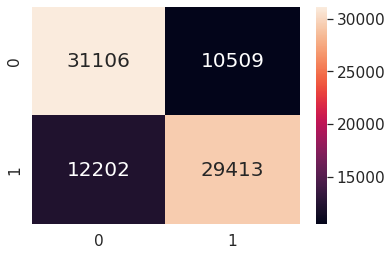

In [ ]:
import seaborn as sns
sns.set(font_scale=1.4)#for label size
sns.heatmap(Confusion_metrix_Train_data,annot=True, annot_kws={"size": 20},fmt ="g")

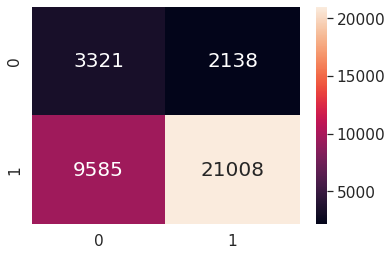

In [ ]:
sns.heatmap(Confusion_metrix_Test_data,annot=True, annot_kws={"size": 20},fmt ="g")

## Summary Set 1
   

*   The BOW for set 1 , gives us the results with a good accuracy which resembles that it is a good model and will give good results when tested
*   The Confusion matrix gives us the TRP and FPR and it has been set with thershold of 0.535, as we wanted to maximise the TPR with the help of setting the thershold.
*   The model of BOW is not performing as expected beacuse it doesn't consider the least occuring words to be important it just creates a orthogonal vector of the words which are present and does not preserve the schematic meaning of the words too.





#### Set 2

In [ ]:
from scipy.sparse import hstack
X2_tr = hstack((x_train_cc_ohe,x_train_cleansubcat_ohe,x_train_tp_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_essay_tfidf,x_train_price_norm,x_train_projects_norm)).tocsr()
X2_cv = hstack((X_cv_cc_ohe,X_cv_cleansubcat_ohe,X_cv_tp_ohe,X_cv_state_ohe,\
                X_cv_grade_ohe,X_cv_essay_tfidf,X_cv_price_norm,X_cv_projects_norm)).tocsr()
X2_te =hstack((X_test_cc_ohe,X_test_cleansubcat_ohe,X_test_tp_ohe,X_test_state_ohe,\
                X_test_grade_ohe,X_test_essay_tfidf,X_test_price_norm,X_test_projects_norm)).tocsr()


print("Final Data matrix")
print(X2_tr.shape, y_train.shape)
print(X2_cv.shape, y_cv.shape)
print(X2_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(83230, 15212) (83230,)
(24155, 15212) (24155,)
(36052, 15212) (36052,)


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


Ploting the Log values of alpha as it would exactly plot the values of the point's considered 


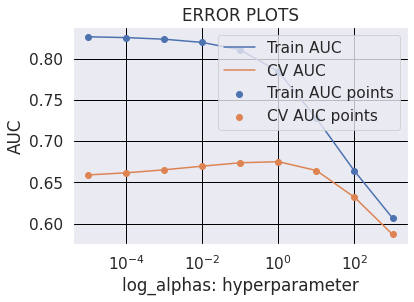

In [ ]:
# Perform Hyperparameter Tuning.
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc1 = []
cv_auc1 = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]
for i in tqdm(alpha):
    neigh = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    neigh.fit(X2_tr, y_train)

    y_train_pred = neigh.predict_proba(X2_tr)[:,1]
    y_cv_pred = neigh.predict_proba(X2_cv)[:,1]

    # roc_auc_score(y_tr, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_auc1.append(roc_auc_score(y_train,y_train_pred))
    cv_auc1.append(roc_auc_score(y_cv, y_cv_pred))

# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
plt.semilogx(alpha, train_auc1, label='Train AUC')
plt.semilogx(alpha, cv_auc1, label='CV AUC')

plt.scatter(alpha, train_auc1, label='Train AUC points')
plt.scatter(alpha, cv_auc1, label='CV AUC points')
print("Ploting the Log values of alpha as it would exactly plot the values of the point's considered ")
plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()


In [ ]:
alpha= 10
print("The Error Plot above shows the best Aplha value as :" , alpha )

The Error Plot above shows the best Aplha value as : 10


In [ ]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=alpha,class_prior=[0.5,0.5])
neigh.fit(X2_tr, y_train)
y_train_pred1 = neigh.predict_proba(X2_tr)[:,1]
y_test_pred1 = neigh.predict_proba(X2_te)[:,1]

# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.


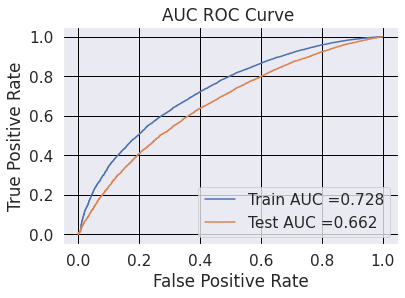

In [ ]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+ str(np.round(auc(train_fpr, train_tpr),3)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(np.round(auc(test_fpr, test_tpr),3)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC ROC Curve ")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()


In [ ]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
#this is the custom function for predecting the best thershold and sorting the values according the threshould
def best_threshold_value(threshold, fpr, tpr):
    n = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),3), "for threshold", np.round(n,3))
    return n

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
print("="*100)
from sklearn.metrics import confusion_matrix
best_n = best_threshold_value(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

print("TN, FP, FN, TP", "=", confusion_matrix(y_train, predict_with_best_n(y_train_pred1, best_n)).ravel())
print("Test confusion matrix")

print("TN, FP, FN, TP", "=", confusion_matrix(y_test, predict_with_best_n(y_test_pred1, best_n)).ravel())
print("here the threshold is ", np.round(best_n,3) , "we can change the threshold values according to Requirement in the confusion meterix")

the maximum value of tpr*(1-fpr) 0.441 for threshold 0.512
Train confusion matrix
TN, FP, FN, TP = [28621 12994 14917 26698]
Test confusion matrix
TN, FP, FN, TP = [ 3358  2101 11486 19107]
here the threshold is  0.512 we can change the threshold values according to Requirement in the confusion meterix


Confusion metrix for Train data 


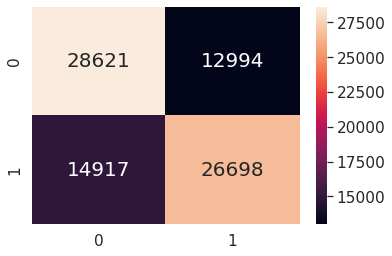

In [ ]:
Confusion_metrix_Train_data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_n)))
Confusion_metrix_Test_data = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_n)))
import seaborn as sns
sns.set(font_scale=1.4)#for label size
print("Confusion metrix for Train data ")
sns.heatmap(Confusion_metrix_Train_data,annot=True, annot_kws={"size": 20},fmt ="g")

Confusion metrix for Test data


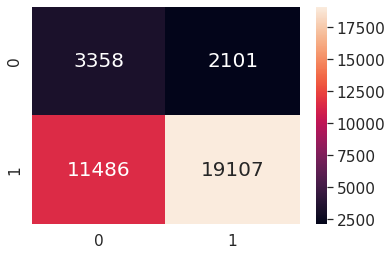

In [ ]:
print("Confusion metrix for Test data")
sns.heatmap(Confusion_metrix_Test_data,annot=True, annot_kws={"size": 20},fmt ="g")

## Summary set 2
* TFIDF vectorizer gives very good results as compared to BOW as it equally considers the occurance of words in the Document Corpus
The AUC was found around 70 % and hence could be increased by using N-grams.
* The AUC was found around 70 % and hence could be increased by using N-grams.
* The confusion matrix was formed using the thershould of 0.45 for maximising the TPR.

In [ ]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)
# Feature set Consitis of all the Catogorial and Numerical features of BOW vectorization

from scipy.sparse import hstack
X1_tr = hstack((x_train_cc_ohe,x_train_cleansubcat_ohe,x_train_tp_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_essay_bow,x_train_price_norm,x_train_projects_norm)).tocsr()
X1_cv = hstack((X_cv_cc_ohe,X_cv_cleansubcat_ohe,X_cv_tp_ohe,X_cv_state_ohe,\
                X_cv_grade_ohe,X_cv_essay_bow,X_cv_price_norm,X_cv_projects_norm)).tocsr()
X1_te =hstack((X_test_cc_ohe,X_test_cleansubcat_ohe,X_test_tp_ohe,X_test_state_ohe,\
                X_test_grade_ohe,X_test_essay_bow,X_test_price_norm,X_test_projects_norm)).tocsr()


print("Final Data matrix")
print(X1_tr.shape, y_train.shape)
print(X1_cv.shape, y_cv.shape)
print(X1_te.shape, y_test.shape)
print("="*100)


Final Data matrix
(83230, 50101) (83230,)
(24155, 50101) (24155,)
(36052, 50101) (36052,)


In [ ]:
nb_bow = MultinomialNB(alpha =alpha1 ,class_prior=[0.5,0.5])
nb_bow.fit(X1_tr, y_train)

MultinomialNB(alpha=100, class_prior=[0.5, 0.5])

In [ ]:
neg_class_prob_sorted = nb_bow.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_bow.feature_log_prob_[1, :].argsort()

In [ ]:
# https://stackoverflow.com/questions/14131615/possible-to-append-multiple-lists-at-once-python
from itertools import chain
Stacked_Feature_list = list(chain(vectorizer_csc.get_feature_names(),vectorizer_cc.get_feature_names(),vectorizer_tp.get_feature_names(),\
                                  vectorizer_ss.get_feature_names(),vectorizer_pgc.get_feature_names(),vectorizer_ess.get_feature_names(),\
                                  x_train_projects_norm,x_train_price_norm))

In [ ]:
print("The words with higest importance in Postive class is")
print(np.take(Stacked_Feature_list, neg_class_prob_sorted[-40:-1]))
print("*"*20)
print("The words with higest importance in Negative class is")
print(np.take(Stacked_Feature_list, pos_class_prob_sorted[-40:-1]))

The words with higest importance in Postive class is
['time' 'student' 'mrs' 'these' 'also' 'technology' 'would' 'this' 'new'
 'make' 'want' 'year' 'class' 'our' 'day' 'reading' 'skills' 'use'
 'materials' 'able' 'love' array([1.]) 'come' 'work' 'need' 'we' 'many'
 'nannan' array([0.]) 'my students' 'the' 'help' 'they' 'not' 'learn'
 'classroom' 'my' 'learning' 'school']
********************
The words with higest importance in Negative class is
['one' 'student' 'mrs' 'want' 'time' 'make' 'year' 'new' 'this' 'skills'
 'books' 'also' 'technology' 'our' 'would' 'class' 'come' 'able' 'day'
 'love' array([1.]) 'use' 'work' 'reading' 'need' 'we' 'nannan' 'many'
 array([0.]) 'help' 'learn' 'my students' 'not' 'they' 'the' 'classroom'
 'learning' 'my' 'school']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [ ]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", " Test AUC"]
x.add_row(["BOW", "Multinomial Naive Bayes", 0.01, 0.70])
x.add_row(["TFIDF", "Multinomial Naive Bayes", 0.01, 0.67])
print(x)
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

+------------+-------------------------+-----------------------+-----------+
| Vectorizer |          Model          | Alpha:Hyper Parameter |  Test AUC |
+------------+-------------------------+-----------------------+-----------+
|    BOW     | Multinomial Naive Bayes |          0.01         |    0.7    |
|   TFIDF    | Multinomial Naive Bayes |          0.01         |    0.67   |
+------------+-------------------------+-----------------------+-----------+
